In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.models import load_model
from yad2k.utils.yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.keras_yolo import yolo_head, yolo_boxes_to_corners
from lane_utils import *
import time
%matplotlib inline

### Filtering with a threshold on class scores


In [3]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    
    # Step 1: Compute box scores
    box_scores = box_confidence * box_class_probs #multiply box probability(p) with class probability
    
    # Step 2: Find the box_classes thanks to the max box_scores, keep track of the corresponding score
    box_classes = K.argmax(box_scores, axis=-1) #max class index
    box_class_scores = K.max(box_scores, axis=-1) #max class probability
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    filtering_mask = box_class_scores>=threshold
    
    # Step 4: Apply the mask to scores, boxes and classes
    scores = tf.boolean_mask(tensor=box_class_scores, mask=filtering_mask, name='score_mask')
    boxes  = tf.boolean_mask(tensor=boxes, mask=filtering_mask, name='box_mask')
    classes = tf.boolean_mask(tensor=box_classes, mask=filtering_mask, name='classes_mask')
    
    return scores, boxes, classes

### Non-max suppression ###

In [4]:

def iou(box1, box2):

    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    xi1 = max(box1[0],box2[0])
    yi1 = max(box1[1],box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = abs(xi1-xi2) * abs(yi1-yi2)

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = abs(box1[0]-box1[2]) * abs(box1[1]-box1[3])
    box2_area = abs(box2[0]-box2[2]) * abs(box2[1]-box2[3])
    union_area = box1_area + box2_area -inter_area
    
    # compute the IoU
    iou = inter_area/union_area

    return iou

In [5]:
# example of IOU
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4) 
print("iou = " + str(iou(box1, box2)))

iou = 0.14285714285714285


With computing iou, we co mposed the third part of non max supression algorithm, now, lets combine everything into one :

In [6]:

def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    nms_indices = tf.image.non_max_suppression(boxes=boxes, 
                                               scores=scores,
                                               max_output_size=max_boxes, 
                                               iou_threshold=iou_threshold, name='nms_indices')
    
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    
    return scores, boxes, classes

### Wrapping up the filtering

In [7]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    
    
    # Retrieve outputs of the YOLO model (≈1 line)
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions 
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # Use one of the functions you've implemented to perform Non-max suppression with a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
        
    return scores, boxes, classes

## YOLO V2. Model

You can find pretrained weights <a href = "http://pjreddie.com/media/files/yolo.weights"> here</a>

In [8]:
sess = K.get_session()

2022-04-12 07:58:15.668260: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


### Defining classes, anchors and image shape.

# Anchor Boxes

## Reading class/anchors data

In [9]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
print(anchors)
image_shape = (720., 1280.)    

model_data/yolo_anchors.txt
[[0.57273  0.677385]
 [1.87446  2.06253 ]
 [3.33843  5.47434 ]
 [7.88282  3.52778 ]
 [9.77052  9.16828 ]]


### Loading a pretrained model

For the purpose of this project, I'm using a pretrained weights for Yolo V2.
You can download the weights <a href = "https://www.kaggle.com/rmoharir8396/yolo-h5-file"> here</a>

In [10]:
yolo_model = load_model("yolo.h5")


/Users/abbasihsna/learning/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [11]:
# now we can see the summary of the neural net
yolo_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

### Convert output of the model to usable bounding box tensors


In [12]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
print(yolo_outputs)

(<tf.Tensor 'Sigmoid:0' shape=(?, ?, ?, 5, 1) dtype=float32>, <tf.Tensor 'truediv:0' shape=(?, ?, ?, 5, 2) dtype=float32>, <tf.Tensor 'truediv_1:0' shape=(?, ?, ?, 5, 2) dtype=float32>, <tf.Tensor 'Softmax:0' shape=(?, ?, ?, 5, 80) dtype=float32>)


### Filtering boxes

In [13]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)
print(scores)
print(boxes)
print(classes)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Tensor("embedding_lookup/Identity:0", shape=(?,), dtype=float32)
Tensor("embedding_lookup_1/Identity:0", shape=(?, 4), dtype=float32)
Tensor("embedding_lookup_2/Identity:0", shape=(?,), dtype=int64)


### Run on an image

In [14]:
def preprocess_image(img_path, model_image_size):
    img_resized = cv2.resize(img_path, model_image_size).astype(np.float32)
    img_resized/=255.
    image_data = img_resized
    
    #print(image_data)
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    #img_path=cv2.cvtColor(img_path, cv2.COLOR_BGR2RGB)
    return img_path, image_data

In [15]:
from PIL import Image

def predict(sess, image_file):
    # Preprocess your image
    image, image_data = preprocess_image(image_file, model_image_size = (608, 608))
    
    image = Image.fromarray(image.astype('uint8'), 'RGB')

    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    # You'll need to use feed_dict={yolo_model.input: ... , K.learning_phase(): 0})
    out_scores, out_boxes, out_classes = sess.run([scores,boxes,classes], 
                                                  feed_dict = {yolo_model.input:image_data, K.learning_phase():0})


    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    drawer=draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)


    return out_scores, out_boxes, out_classes, drawer

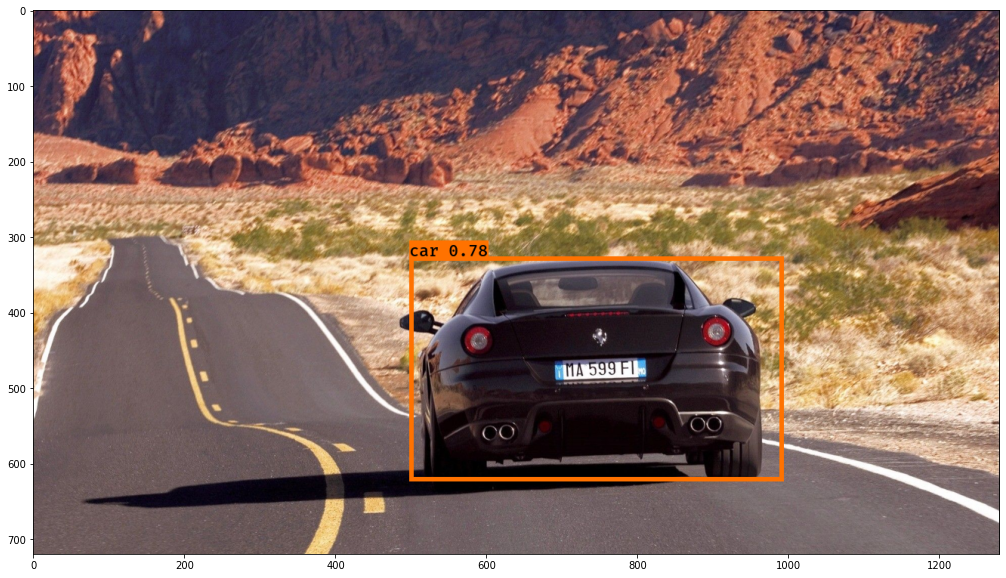

In [16]:
image = cv2.imread('../test_images/test01.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (1280,720))
out_scores, out_boxes, out_classes, drawer = predict(sess, image)

plt.figure(figsize=(20,10))
plt.imshow(drawer)

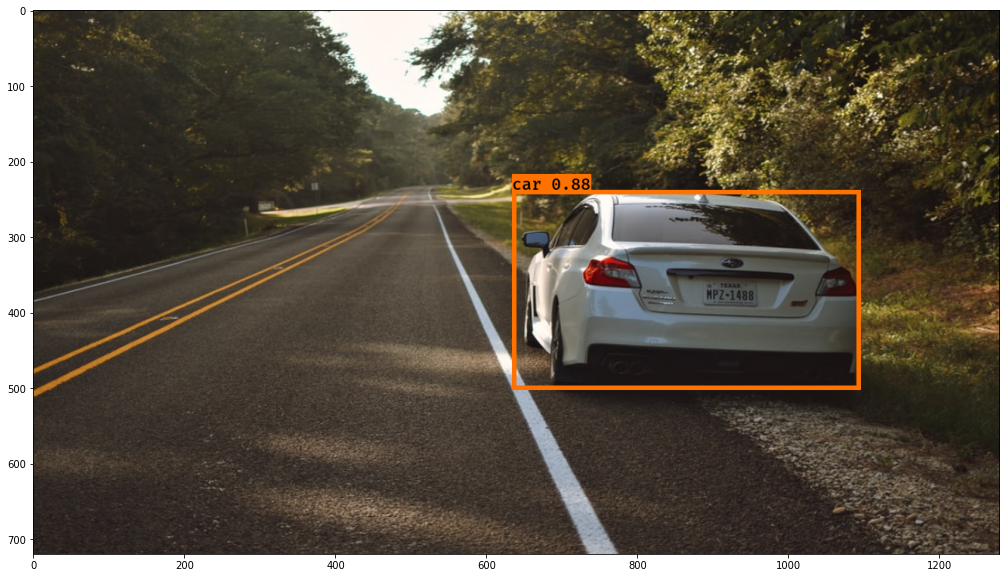

In [41]:
image = cv2.imread('../test_images/test02.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (1280,720))
out_scores, out_boxes, out_classes, drawer = predict(sess, image)

plt.figure(figsize=(20,10))
plt.imshow(drawer)

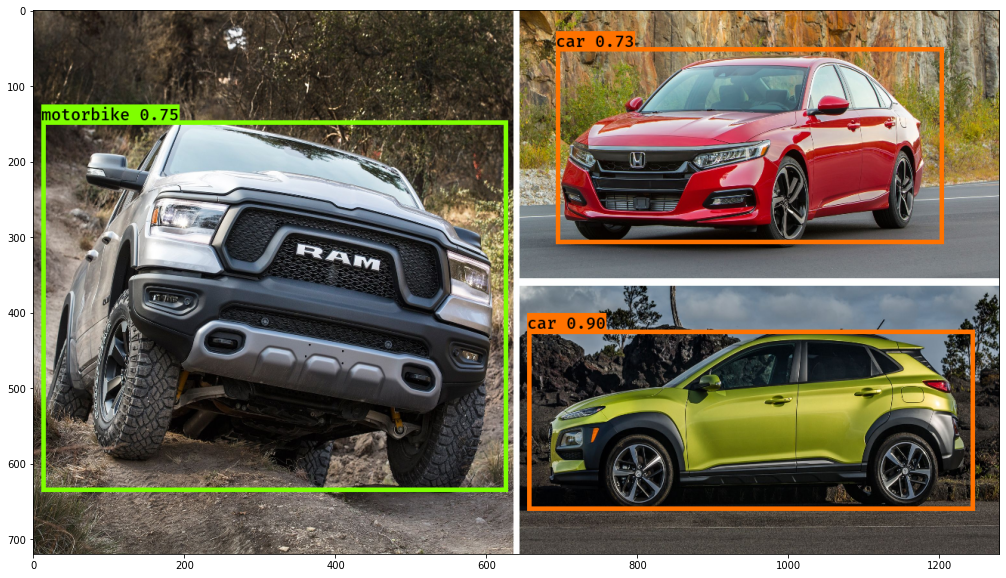

In [42]:
image = cv2.imread('../test_images/test03.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (1280,720))
out_scores, out_boxes, out_classes, drawer = predict(sess, image)

plt.figure(figsize=(20,10))
plt.imshow(drawer)